In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

import BiomassConversions_PugetSound

%matplotlib inline



# Import Puget Sound data and create dataframe

In [2]:
df=pd.read_excel('/ocean/ksuchy/MOAD/observe/SSMSP_TransBoundary_Extract_2014-2019_Verticals_Keister_Lab.xlsx',engine='openpyxl',sheet_name='SSMSP 2014-2019 Density&Biomass')

In [3]:
df

,BugSampleID,Project,Sample Code,Sampling Group,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,...,Ind Carbon (ug),Density (#/m3),Final Carbon (mg/m3),Species Size Category Aggregation,Size Category Aggregation,Collection Confidence,Carbon Regression EQ,C to DW multipier,DW Regression Equation,C/DW Source
0,93945,SSMSP,060817HCB004V1454,HCSEG,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,...,122.333000,5.169013,3.185477,Amphipod,Amphipod,High,C(ug)=(0.0049*([Length(mm)])^2.957)*1000)*37%,C = DW * 37%,DW(ug)=0.0049*([Length(mm)])^2.957)*1000,"Ikeda & Shiga, 1999"
1,93946,SSMSP,060817HCB004V1454,HCSEG,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,...,107.303200,0.068013,0.010533,Amphipod,Amphipod,High,C(ug)=(0.0049*([Length(mm)])^2.957)*1000)*37%,C = DW * 37%,DW(ug)=0.0049*([Length(mm)])^2.957)*1000,"Ikeda & Shiga, 1999"
2,93962,SSMSP,060817HCB004V1454,HCSEG,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,...,17.764660,21.764267,0.397324,Amphipod,Amphipod,High,C(ug)=(0.0049*([Length(mm)])^2.957)*1000)*37%,C = DW * 37%,DW(ug)=0.0049*([Length(mm)])^2.957)*1000,"Ikeda & Shiga, 1999"
3,94018,SSMSP,030917HCB003V1218,HCSEG,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,...,343.152100,1.730036,0.564992,Amphipod,Amphipod,High,C(ug)=((0.02 * [Length (mm)]^2.1)*1000)*37%,C = DW * 37%,DW(μg) = (0.02 * [Length(mm)]^2.1)*1000,"Kafanov & Fedotov, 1982"
4,94030,SSMSP,030917HCB003V1218,HCSEG,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,...,17.764660,0.812593,0.090677,Amphipod,Amphipod,High,C(ug)=(0.0049*([Length(mm)])^2.957)*1000)*37%,C = DW * 37%,DW(ug)=0.0049*([Length(mm)])^2.957)*1000,"Ikeda & Shiga, 1999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81582,31509,SSMSP,050615MUKV1200,TUL,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,...,7.450710,98.804469,0.252324,Unknown Egg,Unknown Egg,Moderate,C (ug) = 8.0935*[Length (mm)]-1.0883,C (ug) = 8.0935*[Length (mm)]-1.0883,NONE,"Keister Lab estimate, 2016"
81583,38434,SSMSP,081315MUKV1121,TUL,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,...,7.450710,8.634707,0.011568,Unknown Egg,Unknown Egg,Moderate,C (ug) = 8.0935*[Length (mm)]-1.0883,C (ug) = 8.0935*[Length (mm)]-1.0883,NONE,"Keister Lab estimate, 2016"
81584,38675,SSMSP,082615MUKV1116,TUL,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,...,2.868051,27.045302,0.077567,Unknown Egg,Unknown Egg,Moderate,C (ug) = 8.0935*[Length (mm)]-1.0883,C (ug) = 8.0935*[Length (mm)]-1.0883,NONE,"Keister Lab estimate, 2016"
81585,39535,SSMSP,050615CAMV1305,TUL,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,...,7.450710,43.628610,0.325064,Unknown Egg,Unknown Egg,Moderate,C (ug) = 8.0935*[Length (mm)]-1.0883,C (ug) = 8.0935*[Length (mm)]-1.0883,NONE,"Keister Lab estimate, 2016"


In [4]:
df.keys()

Index(['BugSampleID', 'Project', 'Sample Code', 'Sampling Group', 'Station',
       'Site Name', 'Basin', 'Sub Basin', 'Latitude', 'Longitude',
       'Date Category', 'Sample Date', 'Sample Year', 'Sample Month',
       'Sample Time', 'Tow Type', 'Mesh Size', 'Diameter (cm)',
       'Station Depth (m)', 'Max Tow Depth (m)', 'Min Tow Depth (m)',
       'Vol Filtered (m3)', 'Broad Group', 'Mid-Level Group', '1st Word Taxa',
       'Genus species', 'Life History Stage', 'Total Ct', 'Ind Carbon (ug)',
       'Density (#/m3)', 'Final Carbon (mg/m3)',
       'Species Size Category Aggregation', 'Size Category Aggregation',
       'Collection Confidence', 'Carbon Regression EQ', 'C to DW multipier',
       'DW Regression Equation', 'C/DW Source'],
      dtype='object')

In [5]:
df.drop(labels=['BugSampleID','Project','Sampling Group','Date Category','Tow Type','Species Size Category Aggregation','Collection Confidence','Carbon Regression EQ','C to DW multipier','DW Regression Equation','C/DW Source'
                       ],axis=1,inplace=True)

In [6]:
df

,Sample Code,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,Sample Date,Sample Year,Sample Month,...,Broad Group,Mid-Level Group,1st Word Taxa,Genus species,Life History Stage,Total Ct,Ind Carbon (ug),Density (#/m3),Final Carbon (mg/m3),Size Category Aggregation
0,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipod,Amphipoda-Hyperiidea,HYPEROCHE,HYPEROCHE,Unknown,76.0,122.333000,5.169013,3.185477,Amphipod
1,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipod,Amphipoda-Hyperiidea,HYPERIA,HYPERIA,Unknown,1.0,107.303200,0.068013,0.010533,Amphipod
2,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipod,Amphipoda-Hyperiidea,THEMISTO,THEMISTO PACIFICA,Unknown,320.0,17.764660,21.764267,0.397324,Amphipod
3,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,Amphipod,Amphipoda-Cyphocarididae,CYPHOCARIS,CYPHOCARIS CHALLENGERI,Unknown,66.0,343.152100,1.730036,0.564992,Amphipod
4,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,Amphipod,Amphipoda-Hyperiidea,THEMISTO,THEMISTO PACIFICA,Unknown,31.0,17.764660,0.812593,0.090677,Amphipod
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81582,050615MUKV1200,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-05-06,2015,MAY,...,Unknown Egg,Unknown,UNKNOWN,UNKNOWN,EGG Lg,4500.0,7.450710,98.804469,0.252324,Unknown Egg
81583,081315MUKV1121,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-13,2015,AUG,...,Unknown Egg,Unknown,UNKNOWN,UNKNOWN,EGG Lg,385.0,7.450710,8.634707,0.011568,Unknown Egg
81584,082615MUKV1116,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-26,2015,SEP,...,Unknown Egg,Unknown,UNKNOWN,UNKNOWN,EGG Med,1000.0,2.868051,27.045302,0.077567,Unknown Egg
81585,050615CAMV1305,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-05-06,2015,MAY,...,Unknown Egg,Unknown,UNKNOWN,UNKNOWN,EGG Lg,2025.0,7.450710,43.628610,0.325064,Unknown Egg


In [7]:
df['Name']=df['Genus species'].str.cat(df[['Life History Stage']], sep=' ')

In [8]:
df.keys()

Index(['Sample Code', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Latitude',
       'Longitude', 'Sample Date', 'Sample Year', 'Sample Month',
       'Sample Time', 'Mesh Size', 'Diameter (cm)', 'Station Depth (m)',
       'Max Tow Depth (m)', 'Min Tow Depth (m)', 'Vol Filtered (m3)',
       'Broad Group', 'Mid-Level Group', '1st Word Taxa', 'Genus species',
       'Life History Stage', 'Total Ct', 'Ind Carbon (ug)', 'Density (#/m3)',
       'Final Carbon (mg/m3)', 'Size Category Aggregation', 'Name'],
      dtype='object')

In [9]:
df

,Sample Code,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,Sample Date,Sample Year,Sample Month,...,Mid-Level Group,1st Word Taxa,Genus species,Life History Stage,Total Ct,Ind Carbon (ug),Density (#/m3),Final Carbon (mg/m3),Size Category Aggregation,Name
0,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipoda-Hyperiidea,HYPEROCHE,HYPEROCHE,Unknown,76.0,122.333000,5.169013,3.185477,Amphipod,HYPEROCHE Unknown
1,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipoda-Hyperiidea,HYPERIA,HYPERIA,Unknown,1.0,107.303200,0.068013,0.010533,Amphipod,HYPERIA Unknown
2,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,Amphipoda-Hyperiidea,THEMISTO,THEMISTO PACIFICA,Unknown,320.0,17.764660,21.764267,0.397324,Amphipod,THEMISTO PACIFICA Unknown
3,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,Amphipoda-Cyphocarididae,CYPHOCARIS,CYPHOCARIS CHALLENGERI,Unknown,66.0,343.152100,1.730036,0.564992,Amphipod,CYPHOCARIS CHALLENGERI Unknown
4,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,Amphipoda-Hyperiidea,THEMISTO,THEMISTO PACIFICA,Unknown,31.0,17.764660,0.812593,0.090677,Amphipod,THEMISTO PACIFICA Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81582,050615MUKV1200,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-05-06,2015,MAY,...,Unknown,UNKNOWN,UNKNOWN,EGG Lg,4500.0,7.450710,98.804469,0.252324,Unknown Egg,UNKNOWN EGG Lg
81583,081315MUKV1121,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-13,2015,AUG,...,Unknown,UNKNOWN,UNKNOWN,EGG Lg,385.0,7.450710,8.634707,0.011568,Unknown Egg,UNKNOWN EGG Lg
81584,082615MUKV1116,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-26,2015,SEP,...,Unknown,UNKNOWN,UNKNOWN,EGG Med,1000.0,2.868051,27.045302,0.077567,Unknown Egg,UNKNOWN EGG Med
81585,050615CAMV1305,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-05-06,2015,MAY,...,Unknown,UNKNOWN,UNKNOWN,EGG Lg,2025.0,7.450710,43.628610,0.325064,Unknown Egg,UNKNOWN EGG Lg


In [10]:
#load biomass conversions file
dfbc=BiomassConversions_PugetSound.LoadConversions()

In [11]:
#merge original dataframe and conversions file
df2=pd.merge(df,dfbc,how='right',left_on=['Name'],right_on=['Species'])

In [12]:
df2

,Sample Code,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,Sample Date,Sample Year,Sample Month,...,Species,FunctionName,PugetSoundIndWeight(ug),PugetSoundIndWeight(mg),SoGIndWeight,c1,Unnamed: 9,Unnamed: 10,Unnamed: 11,BiomassPerIndividual
0,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,"ACARTIA HUDSONICA Female, Adult",SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025
1,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,"ACARTIA HUDSONICA Female, Adult",SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025
2,030917HCB004V1318,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-03-09,2017,MAR,...,"ACARTIA HUDSONICA Female, Adult",SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025
3,040617HCB004V1334,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-04-06,2017,APR,...,"ACARTIA HUDSONICA Female, Adult",SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025
4,051817HCB003V1215,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-05-18,2017,MAY,...,"ACARTIA HUDSONICA Female, Adult",SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42094,082615MUKV1116,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-26,2015,SEP,...,OIKOPLEURA Unknown,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000
42095,050615CAMV1305,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-05-06,2015,MAY,...,OIKOPLEURA Unknown,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000
42096,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,JAN,...,OIKOPLEURA Unknown,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000
42097,032015CAMV1246,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-03-20,2015,MAR,...,OIKOPLEURA Unknown,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000


In [13]:
#calculate a new biomass column using Puget Sound carbon conversion equations
df2['NewBiomass']=np.nan
for i,row in df2.iterrows():
    df2.at[i,'NewBiomass']=row['Density (#/m3)']*row['BiomassPerIndividual']

In [14]:
df2

,Sample Code,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,Sample Date,Sample Year,Sample Month,...,FunctionName,PugetSoundIndWeight(ug),PugetSoundIndWeight(mg),SoGIndWeight,c1,Unnamed: 9,Unnamed: 10,Unnamed: 11,BiomassPerIndividual,NewBiomass
0,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.340874
1,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.001327
2,030917HCB004V1318,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-03-09,2017,MAR,...,SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.959248
3,040617HCB004V1334,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-04-06,2017,APR,...,SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.501182
4,051817HCB003V1215,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-05-18,2017,MAY,...,SoG1,2.58,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.006158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42094,082615MUKV1116,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-26,2015,SEP,...,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,52.738339
42095,050615CAMV1305,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-05-06,2015,MAY,...,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,34.902888
42096,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,JAN,...,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,2.353078
42097,032015CAMV1246,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-03-20,2015,MAR,...,SoG1,1.61,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,111.995292


In [15]:
#column for old biomass converted 
df2['OldBiomass']=df2['Final Carbon (mg/m3)']

In [16]:
df2['BiomassDiff']=df2['NewBiomass']-df2['OldBiomass']

In [17]:
df2

,Sample Code,Station,Site Name,Basin,Sub Basin,Latitude,Longitude,Sample Date,Sample Year,Sample Month,...,PugetSoundIndWeight(mg),SoGIndWeight,c1,Unnamed: 9,Unnamed: 10,Unnamed: 11,BiomassPerIndividual,NewBiomass,OldBiomass,BiomassDiff
0,060817HCB004V1454,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-06-08,2017,JUN,...,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.340874,0.434591,-0.093717
1,030917HCB003V1218,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-03-09,2017,MAR,...,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.001327,0.001692,-0.000365
2,030917HCB004V1318,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-03-09,2017,MAR,...,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.959248,1.222975,-0.263727
3,040617HCB004V1334,HCB004V,Sisters Point,Hood Canal,S Hood Canal,47.35620,-123.0249,2017-04-06,2017,APR,...,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.501182,0.638973,-0.137791
4,051817HCB003V1215,HCB003V,Eldon,Hood Canal,S Hood Canal,47.53787,-123.0096,2017-05-18,2017,MAY,...,0.00258,0.0045,0.45,NaN,NaN,NaN,0.002025,0.006158,0.007851,-0.001693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42094,082615MUKV1116,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-08-26,2015,SEP,...,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,52.738339,0.283029,52.455310
42095,050615CAMV1305,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-05-06,2015,MAY,...,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,34.902888,0.187312,34.715576
42096,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,JAN,...,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,2.353078,0.012628,2.340450
42097,032015CAMV1246,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-03-20,2015,MAR,...,0.00161,0.3000,1.00,NaN,NaN,NaN,0.300000,111.995292,0.601041,111.394250


In [18]:
#Determine which species are making up most of the biomass in each Order
biomassSumsNew=df2.loc[:,['Genus species','Life History Stage','OldBiomass','NewBiomass']].groupby(['Genus species','Life History Stage'],as_index=False)\
        .sum().sort_values(['NewBiomass'],ascending=False).reset_index()
biomassSumsNew.head(50)

,index,Genus species,Life History Stage,OldBiomass,NewBiomass
0,92,OIKOPLEURA,Unknown,614.500459,114503.190076
1,112,THEMISTO PACIFICA,Unknown,560.473474,17193.218967
2,29,CYPHOCARIS CHALLENGERI,Unknown,1183.031383,4677.234682
3,10,CALANUS PACIFICUS,"5, CV",995.503996,3660.418005
4,11,CALANUS PACIFICUS,"Female, Adult",723.815888,2213.808842
5,63,LIMACINA HELICINA,Unknown,13.452976,1789.852074
6,12,CALANUS PACIFICUS,"Male, Adult",517.024875,1403.294598
7,86,METRIDIA PACIFICA,"Female, Adult",817.733036,1051.687859
8,95,PARACALANUS,"Female, Adult",1093.276194,964.713495
9,55,GAMMARIDEA,Unknown,17.230196,867.758403


In [19]:
biomassSumsNew['FracAcctd']=0
for ii in range(0,len(biomassSumsNew)):
    biomassSumsNew.loc[ii,['FracAcctd']]=np.sum(biomassSumsNew.loc[:(ii+1),['NewBiomass']].values)/np.sum(biomassSumsNew.loc[:,['NewBiomass']].values)

In [20]:
biomassSumsNew.head(50)

,index,Genus species,Life History Stage,OldBiomass,NewBiomass,FracAcctd
0,92,OIKOPLEURA,Unknown,614.500459,114503.190076,0.843332
1,112,THEMISTO PACIFICA,Unknown,560.473474,17193.218967,0.873283
2,29,CYPHOCARIS CHALLENGERI,Unknown,1183.031383,4677.234682,0.896723
3,10,CALANUS PACIFICUS,"5, CV",995.503996,3660.418005,0.910899
4,11,CALANUS PACIFICUS,"Female, Adult",723.815888,2213.808842,0.922360
5,63,LIMACINA HELICINA,Unknown,13.452976,1789.852074,0.931347
6,12,CALANUS PACIFICUS,"Male, Adult",517.024875,1403.294598,0.938081
7,86,METRIDIA PACIFICA,"Female, Adult",817.733036,1051.687859,0.944259
8,95,PARACALANUS,"Female, Adult",1093.276194,964.713495,0.949816
9,55,GAMMARIDEA,Unknown,17.230196,867.758403,0.954890


In [21]:
colListGenus=('ACARTIA HUDSONICA','ACARTIA LONGIREMIS','AETIDEUS',\
    'CALANUS MARSHALLAE','CALANUS PACIFICUS','CENTROPAGES ABDOMINALIS',\
    'DITRICHOCORYCAEUS ANGLICUS','EPILABIDOCERA AMPHITRITES','EUCALANUS',\
    'EUCALANUS BUNGII','METRIDIA PACIFICA','MICROCALANUS','NEOCALANUS PLUMCHRUS',\
    'OITHONA SIMILIS','PARACALANUS','PARAEUCHAETA ELONGATA','PSEUDOCALANUS',\
    'PSEUDOCALANUS Lg','PSEUDOCALANUS MIMUS','PSEUDOCALANUS MOULTONI',\
    'PSEUDOCALANUS NEWMANI','PSEUDOCALANUS Sm','CYPHOCARIS CHALLENGERI',\
    'CALLIOPIUS PACIFICUS','GAMMARIDEA','THEMISTO PACIFICA','EUPHAUSIA PACIFICA',\
    'THYSANOESSA RASCHII','GASTROPODA','CLIONE LIMACINA','LIMACINA HELICINA',\
    'CHAETOGNATHA','FABIA SUBQUADRATA','CANCER PRODUCTUS','CANCRIDAE','Cancridae Lg',\
    'Cancridae Sm','GLEBOCARCINUS OREGONENSIS','LOPHOPANOPEUS BELLUS','METACARCINUS GRACILIS',\
    'METACARCINUS MAGISTER','PINNIXA','PINNOTHERES','PUGETTIA','OIKOPLEURA')



## Convert date to proper format

In [22]:
df2['Sample Date'][0],df2['Sample Time'][0]

(Timestamp('2017-06-08 00:00:00'), datetime.time(14, 54))

In [23]:
df2['Sample Date'][1000:1020]

1000   2019-07-15
1001   2019-08-13
1002   2019-05-19
1003   2019-03-15
1004   2019-10-29
1005   2019-11-18
1006   2019-02-16
1007   2019-11-18
1008   2019-11-02
1009   2014-05-16
1010   2014-06-27
1011   2014-05-15
1012   2014-05-31
1013   2014-06-01
1014   2014-09-12
1015   2014-06-12
1016   2014-07-11
1017   2014-07-26
1018   2014-09-11
1019   2014-08-30
Name: Sample Date, dtype: datetime64[ns]

In [24]:
df2['dtPac']=[dt.datetime.combine(idate, itime) for idate, itime \
                 in zip(df2['Sample Date'],df2['Sample Time'])]

In [25]:
df2['dtUTC']=[et.pac_to_utc(ii) for ii in df2['dtPac']]

In [26]:
df2['dtUTC']

0       2017-06-08 21:54:00
1       2017-03-09 20:18:00
2       2017-03-09 21:18:00
3       2017-04-06 20:34:00
4       2017-05-18 19:15:00
                ...        
42094   2015-08-26 18:16:00
42095   2015-05-06 20:05:00
42096   2015-01-13 22:15:00
42097   2015-03-20 19:46:00
42098   2015-03-20 18:35:00
Name: dtUTC, Length: 42099, dtype: datetime64[ns]

In [27]:
df2['Sample Month']=[ii.month for ii in df2['dtUTC']]

In [28]:
df2.rename(columns={'Sample Code':'Key','Latitude':'Lat','Longitude':'Lon'},inplace=True)

In [29]:
df2.loc[0]

Key                                        060817HCB004V1454
Station                                              HCB004V
Site Name                                      Sisters Point
Basin                                             Hood Canal
Sub Basin                                       S Hood Canal
Lat                                                  47.3562
Lon                                                 -123.025
Sample Date                              2017-06-08 00:00:00
Sample Year                                             2017
Sample Month                                               6
Sample Time                                         14:54:00
Mesh Size                                                200
Diameter (cm)                                             60
Station Depth (m)                                         52
Max Tow Depth (m)                                         47
Min Tow Depth (m)                                          0
Vol Filtered (m3)       

In [30]:
towIDlist=['Key','Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat',
       'Lon', 'Sample Date', 'Sample Year', 'Sample Month',
       'Sample Time', 'Mesh Size', 'Diameter (cm)', 'Station Depth (m)',
       'Max Tow Depth (m)', 'Min Tow Depth (m)','dtUTC']

In [31]:
towIDlist2=['Key', 'Station', 'Sample Date','Sample Time','dtUTC']

In [32]:
len(df2.groupby(towIDlist)),len(df2.groupby(towIDlist2)),len(df2.groupby(['Key']))

(1682, 1159, 1159)

### Create a biomass dataframe

In [33]:
biomassDF=df2.groupby(towIDlist2,as_index=False).first()\
     .loc[:,towIDlist].copy(deep=True)

In [34]:
biomassDF

,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,Sample Month,Sample Time,Mesh Size,Diameter (cm),Station Depth (m),Max Tow Depth (m),Min Tow Depth (m),dtUTC
0,010218ELIV1151,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2018-01-02,2018,1,11:51:00,200,60.0,120.700,110.0,0,2018-01-02 19:51:00
1,010818SKETV1058,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2018-01-08,2018,1,10:58:00,200,60.0,132.000,122.0,0,2018-01-08 18:58:00
2,011119ELIV1052,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2019-01-11,2019,1,10:52:00,200,60.0,124.054,114.0,0,2019-01-11 18:52:00
3,011315CAMV1330,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-01-13,2015,1,13:30:00,200,60.0,175.000,170.0,0,2015-01-13 21:30:00
4,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,1,14:15:00,200,60.0,200.000,190.0,0,2015-01-13 22:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,121917LSNT01V1000,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2017-12-19,2017,12,10:00:00,200,60.0,210.000,200.0,0,2017-12-19 18:00:00
1155,121917NSEX01V1224,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2017-12-19,2017,12,12:24:00,200,60.0,180.000,170.0,0,2017-12-19 20:24:00
1156,121918TDBV1327,TDBV,Thorndyke Bay,Hood Canal,N Hood Canal,47.78297,-122.7330,2018-12-19,2018,12,13:27:00,200,60.0,112.000,109.0,0,2018-12-19 21:27:00
1157,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,12,10:57:00,200,60.0,210.000,200.0,0,2016-12-21 18:57:00


In [35]:
biomassDF.keys()

Index(['Key', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat', 'Lon',
       'Sample Date', 'Sample Year', 'Sample Month', 'Sample Time',
       'Mesh Size', 'Diameter (cm)', 'Station Depth (m)', 'Max Tow Depth (m)',
       'Min Tow Depth (m)', 'dtUTC'],
      dtype='object')

In [36]:
def getbiomass(colname,key,origdf,matchcol):        
    biomassArray=origdf.loc[(origdf.Key==key)&(origdf[matchcol]==colname),
                    ['NewBiomass']]
    biomass=np.nansum(biomassArray)
    
    return biomass

In [37]:
for icol in colListGenus:
    biomassDF[icol]=[getbiomass(icol,ikey,df2,'Genus species') for ikey in biomassDF['Key']]

In [38]:
biomassDF

,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,Sample Month,...,Cancridae Lg,Cancridae Sm,GLEBOCARCINUS OREGONENSIS,LOPHOPANOPEUS BELLUS,METACARCINUS GRACILIS,METACARCINUS MAGISTER,PINNIXA,PINNOTHERES,PUGETTIA,OIKOPLEURA
0,010218ELIV1151,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2018-01-02,2018,1,...,0.0,0.0,0.0,0.0,0.000000,0.047029,0.0,0.0,0.000000,1.888727
1,010818SKETV1058,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2018-01-08,2018,1,...,0.0,0.0,0.0,0.0,0.002955,0.042446,0.0,0.0,0.000000,21.186442
2,011119ELIV1052,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2019-01-11,2019,1,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,011315CAMV1330,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-01-13,2015,1,...,0.0,0.0,0.0,0.0,0.000000,0.055466,0.0,0.0,0.000000,0.000000
4,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,1,...,0.0,0.0,0.0,0.0,0.000000,0.106333,0.0,0.0,0.000000,2.353078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,121917LSNT01V1000,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2017-12-19,2017,12,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,10.649647
1155,121917NSEX01V1224,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2017-12-19,2017,12,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,32.261477
1156,121918TDBV1327,TDBV,Thorndyke Bay,Hood Canal,N Hood Canal,47.78297,-122.7330,2018-12-19,2018,12,...,0.0,0.0,0.0,0.0,0.000598,0.000000,0.0,0.0,0.000000,5.911330
1157,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,12,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,12.364336


In [39]:
biomassDF.keys()

Index(['Key', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat', 'Lon',
       'Sample Date', 'Sample Year', 'Sample Month', 'Sample Time',
       'Mesh Size', 'Diameter (cm)', 'Station Depth (m)', 'Max Tow Depth (m)',
       'Min Tow Depth (m)', 'dtUTC', 'ACARTIA HUDSONICA', 'ACARTIA LONGIREMIS',
       'AETIDEUS', 'CALANUS MARSHALLAE', 'CALANUS PACIFICUS',
       'CENTROPAGES ABDOMINALIS', 'DITRICHOCORYCAEUS ANGLICUS',
       'EPILABIDOCERA AMPHITRITES', 'EUCALANUS', 'EUCALANUS BUNGII',
       'METRIDIA PACIFICA', 'MICROCALANUS', 'NEOCALANUS PLUMCHRUS',
       'OITHONA SIMILIS', 'PARACALANUS', 'PARAEUCHAETA ELONGATA',
       'PSEUDOCALANUS', 'PSEUDOCALANUS Lg', 'PSEUDOCALANUS MIMUS',
       'PSEUDOCALANUS MOULTONI', 'PSEUDOCALANUS NEWMANI', 'PSEUDOCALANUS Sm',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'GASTROPODA', 'CLIONE LIMACINA', 'LIMACINA HELICINA', 'CHAETOGNATHA',
    

In [40]:
import netCDF4 as nc

In [41]:
#ftemp=nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

In [42]:
#ftemp.variables.keys()

In [43]:
#ftemp.variables['e3t_0']

In [44]:
#ftemp.variables['e3t_1d'][:]

In [45]:
fdict={'ptrc_T':1,'grid_T':1}
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2016,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'microzooplankton':'ptrc_T','mesozooplankton':'ptrc_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1}

In [46]:
PATH= '/results2/SalishSea/nowcast-green.201905/'

In [47]:
biomassDF.keys()

Index(['Key', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat', 'Lon',
       'Sample Date', 'Sample Year', 'Sample Month', 'Sample Time',
       'Mesh Size', 'Diameter (cm)', 'Station Depth (m)', 'Max Tow Depth (m)',
       'Min Tow Depth (m)', 'dtUTC', 'ACARTIA HUDSONICA', 'ACARTIA LONGIREMIS',
       'AETIDEUS', 'CALANUS MARSHALLAE', 'CALANUS PACIFICUS',
       'CENTROPAGES ABDOMINALIS', 'DITRICHOCORYCAEUS ANGLICUS',
       'EPILABIDOCERA AMPHITRITES', 'EUCALANUS', 'EUCALANUS BUNGII',
       'METRIDIA PACIFICA', 'MICROCALANUS', 'NEOCALANUS PLUMCHRUS',
       'OITHONA SIMILIS', 'PARACALANUS', 'PARAEUCHAETA ELONGATA',
       'PSEUDOCALANUS', 'PSEUDOCALANUS Lg', 'PSEUDOCALANUS MIMUS',
       'PSEUDOCALANUS MOULTONI', 'PSEUDOCALANUS NEWMANI', 'PSEUDOCALANUS Sm',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'GASTROPODA', 'CLIONE LIMACINA', 'LIMACINA HELICINA', 'CHAETOGNATHA',
    

In [48]:
biomassDF.rename(columns={'Max Tow Depth (m)':'Z_lower','Min Tow Depth (m)':'Z_upper','Station Depth (m)':'Z'},inplace=True)

In [49]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [50]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [51]:
biomassDF['Year']=[ii.year for ii in biomassDF['dtUTC']]
biomassDF['YD']=et.datetimeToYD(biomassDF['dtUTC'])


In [52]:
#no conversions are needed because values are already in mg C m-3 for Puget Sound
biomassDF['Total']=(biomassDF['ACARTIA HUDSONICA']+ biomassDF['ACARTIA LONGIREMIS']+\
       biomassDF['AETIDEUS']+ biomassDF['CALANUS MARSHALLAE']+biomassDF['CALANUS PACIFICUS']+\
       biomassDF['CENTROPAGES ABDOMINALIS']+biomassDF['DITRICHOCORYCAEUS ANGLICUS']+\
       biomassDF['EPILABIDOCERA AMPHITRITES']+biomassDF['EUCALANUS']+biomassDF['EUCALANUS BUNGII']+\
       biomassDF['METRIDIA PACIFICA']+ biomassDF['MICROCALANUS']+ biomassDF['NEOCALANUS PLUMCHRUS']+\
       biomassDF['OITHONA SIMILIS']+biomassDF['PARACALANUS']+ biomassDF['PARAEUCHAETA ELONGATA']+\
       biomassDF['PSEUDOCALANUS']+biomassDF['PSEUDOCALANUS Lg']+biomassDF['PSEUDOCALANUS MIMUS']+\
       biomassDF['PSEUDOCALANUS MOULTONI']+ biomassDF['PSEUDOCALANUS NEWMANI']+ biomassDF['PSEUDOCALANUS Sm']+\
       biomassDF['CYPHOCARIS CHALLENGERI']+ biomassDF['CALLIOPIUS PACIFICUS']+ biomassDF['GAMMARIDEA']+\
       biomassDF['THEMISTO PACIFICA']+biomassDF['EUPHAUSIA PACIFICA']+biomassDF['THYSANOESSA RASCHII']+\
       biomassDF['GASTROPODA']+ biomassDF['CLIONE LIMACINA']+biomassDF['LIMACINA HELICINA']+ biomassDF['CHAETOGNATHA']+\
       biomassDF['FABIA SUBQUADRATA']+ biomassDF['CANCER PRODUCTUS']+ biomassDF['CANCRIDAE']+ biomassDF['Cancridae Lg']+\
       biomassDF['Cancridae Sm']+ biomassDF['GLEBOCARCINUS OREGONENSIS']+ biomassDF['LOPHOPANOPEUS BELLUS']+\
       biomassDF['METACARCINUS GRACILIS']+ biomassDF['METACARCINUS MAGISTER']+ biomassDF['PINNIXA']+\
       biomassDF['PINNOTHERES']+biomassDF['PUGETTIA']+biomassDF['OIKOPLEURA'])

In [53]:
#Create column for taxa of interest
biomassDF['Copepods']=(biomassDF['ACARTIA HUDSONICA']+ biomassDF['ACARTIA LONGIREMIS']+\
       biomassDF['AETIDEUS']+ biomassDF['CALANUS MARSHALLAE']+biomassDF['CALANUS PACIFICUS']+\
       biomassDF['CENTROPAGES ABDOMINALIS']+biomassDF['DITRICHOCORYCAEUS ANGLICUS']+\
       biomassDF['EPILABIDOCERA AMPHITRITES']+biomassDF['EUCALANUS']+biomassDF['EUCALANUS BUNGII']+\
       biomassDF['METRIDIA PACIFICA']+ biomassDF['MICROCALANUS']+ biomassDF['NEOCALANUS PLUMCHRUS']+\
       biomassDF['OITHONA SIMILIS']+biomassDF['PARACALANUS']+ biomassDF['PARAEUCHAETA ELONGATA']+\
       biomassDF['PSEUDOCALANUS']+biomassDF['PSEUDOCALANUS Lg']+biomassDF['PSEUDOCALANUS MIMUS']+\
       biomassDF['PSEUDOCALANUS MOULTONI']+ biomassDF['PSEUDOCALANUS NEWMANI']+ biomassDF['PSEUDOCALANUS Sm'])

In [54]:
biomassDF['Amphipods']=(biomassDF['CYPHOCARIS CHALLENGERI']+ biomassDF['CALLIOPIUS PACIFICUS']+ biomassDF['GAMMARIDEA']+\
       biomassDF['THEMISTO PACIFICA'])

In [55]:
biomassDF['Euphausiids']=(biomassDF['EUPHAUSIA PACIFICA']+biomassDF['THYSANOESSA RASCHII'])

In [162]:
biomassDF['MainGroups']=(biomassDF['ACARTIA HUDSONICA']+ biomassDF['ACARTIA LONGIREMIS']+\
       biomassDF['AETIDEUS']+ biomassDF['CALANUS MARSHALLAE']+biomassDF['CALANUS PACIFICUS']+\
       biomassDF['CENTROPAGES ABDOMINALIS']+biomassDF['DITRICHOCORYCAEUS ANGLICUS']+\
       biomassDF['EPILABIDOCERA AMPHITRITES']+biomassDF['EUCALANUS']+biomassDF['EUCALANUS BUNGII']+\
       biomassDF['METRIDIA PACIFICA']+ biomassDF['MICROCALANUS']+ biomassDF['NEOCALANUS PLUMCHRUS']+\
       biomassDF['OITHONA SIMILIS']+biomassDF['PARACALANUS']+ biomassDF['PARAEUCHAETA ELONGATA']+\
       biomassDF['PSEUDOCALANUS']+biomassDF['PSEUDOCALANUS Lg']+biomassDF['PSEUDOCALANUS MIMUS']+\
       biomassDF['PSEUDOCALANUS MOULTONI']+ biomassDF['PSEUDOCALANUS NEWMANI']+ biomassDF['PSEUDOCALANUS Sm']+\
        biomassDF['CYPHOCARIS CHALLENGERI']+ biomassDF['CALLIOPIUS PACIFICUS']+ biomassDF['GAMMARIDEA']+\
       biomassDF['THEMISTO PACIFICA']+biomassDF['EUPHAUSIA PACIFICA']+biomassDF['THYSANOESSA RASCHII']+biomassDF['CHAETOGNATHA']+biomassDF['FABIA SUBQUADRATA']+ biomassDF['CANCER PRODUCTUS']+ biomassDF['CANCRIDAE']+ biomassDF['Cancridae Lg']+\
       biomassDF['Cancridae Sm']+ biomassDF['GLEBOCARCINUS OREGONENSIS']+ biomassDF['LOPHOPANOPEUS BELLUS']+\
       biomassDF['METACARCINUS GRACILIS']+ biomassDF['METACARCINUS MAGISTER']+ biomassDF['PINNIXA']+\
       biomassDF['PINNOTHERES']+biomassDF['PUGETTIA'])

In [163]:
biomassDF['Gastropods']=(biomassDF['GASTROPODA']+ biomassDF['CLIONE LIMACINA']+biomassDF['LIMACINA HELICINA'])

In [164]:
biomassDF['Chaetognaths']=(biomassDF['CHAETOGNATHA'])

In [165]:
biomassDF['Crabs']=(biomassDF['FABIA SUBQUADRATA']+ biomassDF['CANCER PRODUCTUS']+ biomassDF['CANCRIDAE']+ biomassDF['Cancridae Lg']+\
       biomassDF['Cancridae Sm']+ biomassDF['GLEBOCARCINUS OREGONENSIS']+ biomassDF['LOPHOPANOPEUS BELLUS']+\
       biomassDF['METACARCINUS GRACILIS']+ biomassDF['METACARCINUS MAGISTER']+ biomassDF['PINNIXA']+\
       biomassDF['PINNOTHERES']+biomassDF['PUGETTIA'])

In [166]:
biomassDF['Larvaceans']=(biomassDF['OIKOPLEURA'])

In [167]:
biomassDF

,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,Sample Month,...,YD,Total,Copepods,Amphipods,Euphausiids,MainGroups,Gastropods,Chaetognaths,Crabs,Larvaceans
0,010218ELIV1151,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2018-01-02,2018,1,...,2,11.101844,3.065202,5.438239,0.154687,9.213117,0.000000,0.507425,0.047564,1.888727
1,010818SKETV1058,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2018-01-08,2018,1,...,8,30.241982,1.482905,7.505748,0.000000,9.041294,0.014246,0.000000,0.052641,21.186442
2,011119ELIV1052,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2019-01-11,2019,1,...,11,8.506914,3.067335,4.452295,0.000000,7.856868,0.650047,0.337238,0.000000,0.000000
3,011315CAMV1330,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-01-13,2015,1,...,13,13.897665,7.412901,6.376149,0.000000,13.848559,0.049107,0.004042,0.055466,0.000000
4,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,1,...,13,24.288932,5.429623,15.713070,0.000000,21.885891,0.049964,0.636865,0.106333,2.353078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,121917LSNT01V1000,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2017-12-19,2017,12,...,353,27.971567,2.634376,14.569518,0.011859,17.222989,0.098930,0.007236,0.000000,10.649647
1155,121917NSEX01V1224,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2017-12-19,2017,12,...,353,60.712435,4.150465,24.121695,0.000000,28.325138,0.125820,0.052978,0.000000,32.261477
1156,121918TDBV1327,TDBV,Thorndyke Bay,Hood Canal,N Hood Canal,47.78297,-122.7330,2018-12-19,2018,12,...,353,23.087564,3.805862,8.147882,0.000000,12.022293,5.153941,0.067951,0.000598,5.911330
1157,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,12,...,356,27.306153,5.710469,9.113340,0.000000,14.885682,0.056134,0.061874,0.000000,12.364336


In [168]:
biomassDF.keys()

Index(['Key', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat', 'Lon',
       'Sample Date', 'Sample Year', 'Sample Month', 'Sample Time',
       'Mesh Size', 'Diameter (cm)', 'Z', 'Z_lower', 'Z_upper', 'dtUTC',
       'ACARTIA HUDSONICA', 'ACARTIA LONGIREMIS', 'AETIDEUS',
       'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'CENTROPAGES ABDOMINALIS',
       'DITRICHOCORYCAEUS ANGLICUS', 'EPILABIDOCERA AMPHITRITES', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'MICROCALANUS',
       'NEOCALANUS PLUMCHRUS', 'OITHONA SIMILIS', 'PARACALANUS',
       'PARAEUCHAETA ELONGATA', 'PSEUDOCALANUS', 'PSEUDOCALANUS Lg',
       'PSEUDOCALANUS MIMUS', 'PSEUDOCALANUS MOULTONI',
       'PSEUDOCALANUS NEWMANI', 'PSEUDOCALANUS Sm', 'CYPHOCARIS CHALLENGERI',
       'CALLIOPIUS PACIFICUS', 'GAMMARIDEA', 'THEMISTO PACIFICA',
       'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII', 'GASTROPODA',
       'CLIONE LIMACINA', 'LIMACINA HELICINA', 'CHAETOGNATHA',
       'FABIA SUBQUADRATA', 'CANCER PROD

In [169]:
biomassDF['Sample Month'][1000:1200]

1000    10
1001    10
1002    10
1003    10
1004    10
        ..
1154    12
1155    12
1156    12
1157    12
1158    12
Name: Sample Month, Length: 159, dtype: int64

In [170]:
print(len(df),'data points')
print('Mean values per month by basin:')
biomassDF.groupby(['Basin','Sample Month']).mean()

81587 data points
Mean values per month by basin:


Lat         Lon  Sample Year  Mesh Size  \
Basin           Sample Month                                                  
Admiralty Inlet 1             48.002730 -122.636000  2018.500000      200.0   
                2             48.002730 -122.636000  2018.666667      200.0   
                3             48.002730 -122.636000  2016.857143      200.0   
                4             48.002730 -122.636000  2017.000000      200.0   
                5             48.002730 -122.636000  2016.363636      200.0   
...                                 ...         ...          ...        ...   
Whidbey Basin   8             48.105715 -122.417072  2016.827586      200.0   
                9             48.167176 -122.456579  2016.666667      200.0   
                10            48.068845 -122.389336  2017.636364      200.0   
                11            48.000777 -122.343900  2017.333333      200.0   
                12            48.029893 -122.365600  2016.500000      200.0   

                              Diameter (cm)           Z     Z_lower  Z_upper  \
Basin           Sample Month                                                   
Admiralty Inlet 1                      60.0  127.500000  112.500000      0.0   
                2                      60.0  127.333333  108.000000      0.0   
                3                      60.0  123.285714  115.714286      0.0   
                4                      60.0  125.000000  115.125000      0.0   
                5                      60.0  123.063636  113.727273      0.0   
...                                     ...         ...         ...      ...   
Whidbey Basin   8                      60.0  152.017241  144.827586      0.0   
                9                      60.0  129.329167  120.583333      0.0   
                10                     60.0  168.581818  158.727273      0.0   
                11                     60.0  190.666667  184.000000      0.0   
                12                     60.0  184.666667  177.666667      0.0   

                              ACARTIA HUDSONICA  ACARTIA LONGIREMIS  ...  \
Basin           Sample Month                                         ...   
Admiralty Inlet 1                      0.000000            0.049059  ...   
                2                      0.008509            0.026979  ...   
                3                      0.021072            0.023581  ...   
                4                      0.070906            0.174898  ...   
                5                      0.183294            0.170874  ...   
...                                         ...                 ...  ...   
Whidbey Basin   8                      0.037375            0.009599  ...   
                9                      0.053524            0.016845  ...   
                10                     0.009245            0.022548  ...   
                11                     0.002565            0.035515  ...   
                12                     0.005162            0.005795  ...   

                                      YD       Total   Copepods  Amphipods  \
Basin           Sample Month                                                 
Admiralty Inlet 1              27.500000   19.297048   4.790356   5.080138   
                2              46.666667   15.568732   3.780140   4.702153   
                3              78.428571  116.331780   5.760913   5.675684   
                4             106.625000  110.950985  12.190950   6.011449   
                5             137.272727  252.221828  22.466842  66.204238   
...                                  ...         ...        ...        ...   
Whidbey Basin   8             232.517241  177.206620  21.091259  37.040576   
                9             261.125000  210.193099  23.051326  20.763181   
                10            288.090909  129.297873  31.699459  25.363484   
                11            322.333333   61.595685  17.392944  25.961821   
                12            338.000000  

In [171]:
monthsFmt = mdates.DateFormatter('%b')

In [172]:
data=et.matchData(biomassDF,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False,method='vertNet');

In [173]:
data

,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,Sample Month,...,Gastropods,Chaetognaths,Crabs,Larvaceans,j,i,mod_microzooplankton,mod_mesozooplankton,k_upper,k_lower
0,032514DANAV1035,DANAV,Dana Passage,South Sound,South Sound,47.18327,-122.8307,2014-03-25,2014,3,...,0.004769,0.002311,0.016915,23.233066,22,126,0.230172,0.624597,0,23
1,040114sketv1001,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2014-04-01,2014,4,...,0.019157,0.071500,0.198317,31.437274,4,147,0.278876,0.450480,0,27
2,040414ADIV1300,ADIV,Admiralty Inlet,Admiralty Inlet,Admiralty Inlet,48.00273,-122.6360,2014-04-04,2014,4,...,0.081804,0.139070,1.201902,70.993919,168,254,0.461681,0.642764,0,26
3,040914ksbp010925,KSBP01V,Point Jefferson,Central Basin,N Central Basin,47.74396,-122.4282,2014-04-09,2014,4,...,0.071266,0.253091,0.293427,213.209469,103,252,0.326967,0.515896,0,30
4,040914lsnt01v1055,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2014-04-09,2014,4,...,0.007204,0.061669,0.090904,165.966006,63,226,0.159925,0.296157,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,112216NSEX01V1304,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2016-11-22,2016,11,...,0.170268,0.014052,0.000000,97.676484,26,212,0.040243,0.365200,0,29
482,120316CAMV1200,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2016-12-03,2016,12,...,0.908612,0.072105,0.000000,6.313483,161,297,0.044915,0.416826,0,30
483,121916KSBP01V1333,KSBP01V,Point Jefferson,Central Basin,N Central Basin,47.74396,-122.4282,2016-12-19,2016,12,...,0.256034,1.078065,0.000000,8.917955,103,252,0.030577,0.293777,0,30
484,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,12,...,0.056134,0.061874,0.000000,12.364336,63,226,0.025608,0.227819,0,30


In [174]:
data.keys()

Index(['Key', 'Station', 'Site Name', 'Basin', 'Sub Basin', 'Lat', 'Lon',
       'Sample Date', 'Sample Year', 'Sample Month', 'Sample Time',
       'Mesh Size', 'Diameter (cm)', 'Z', 'Z_lower', 'Z_upper', 'dtUTC',
       'ACARTIA HUDSONICA', 'ACARTIA LONGIREMIS', 'AETIDEUS',
       'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'CENTROPAGES ABDOMINALIS',
       'DITRICHOCORYCAEUS ANGLICUS', 'EPILABIDOCERA AMPHITRITES', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'MICROCALANUS',
       'NEOCALANUS PLUMCHRUS', 'OITHONA SIMILIS', 'PARACALANUS',
       'PARAEUCHAETA ELONGATA', 'PSEUDOCALANUS', 'PSEUDOCALANUS Lg',
       'PSEUDOCALANUS MIMUS', 'PSEUDOCALANUS MOULTONI',
       'PSEUDOCALANUS NEWMANI', 'PSEUDOCALANUS Sm', 'CYPHOCARIS CHALLENGERI',
       'CALLIOPIUS PACIFICUS', 'GAMMARIDEA', 'THEMISTO PACIFICA',
       'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII', 'GASTROPODA',
       'CLIONE LIMACINA', 'LIMACINA HELICINA', 'CHAETOGNATHA',
       'FABIA SUBQUADRATA', 'CANCER PROD

In [175]:
data.describe()

,Lat,Lon,Sample Year,Sample Month,Mesh Size,Diameter (cm),Z,Z_lower,Z_upper,ACARTIA HUDSONICA,...,Gastropods,Chaetognaths,Crabs,Larvaceans,j,i,mod_microzooplankton,mod_mesozooplankton,k_upper,k_lower
count,486.000000,486.000000,486.000000,486.000000,486.0,486.000000,486.00000,486.000000,486.0,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.0,486.000000
mean,47.835096,-122.577253,2015.117284,6.703704,200.0,59.814815,150.40893,135.004115,0.0,0.079303,...,1.631743,0.449476,1.082397,106.929709,131.039095,242.076132,0.243411,0.672787,0.0,27.312757
std,0.472155,0.200197,0.781638,2.479330,0.0,2.352158,73.50547,58.476253,0.0,0.637344,...,5.356788,0.818413,5.594525,132.718964,96.970484,54.837984,0.143511,0.350562,0.0,2.744239
min,47.152430,-123.048100,2014.000000,1.000000,200.0,30.000000,23.50000,20.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,118.000000,0.017737,0.178979,0.0,18.000000
25%,47.358620,-122.733000,2014.000000,5.000000,200.0,60.000000,110.00000,105.000000,0.0,0.000000,...,0.065105,0.048771,0.016834,22.307109,63.000000,212.000000,0.156428,0.453013,0.0,26.000000
50%,47.743960,-122.569400,2015.000000,7.000000,200.0,60.000000,131.05000,122.000000,0.0,0.000000,...,0.220778,0.161708,0.123728,59.283115,104.000000,252.000000,0.225811,0.618945,0.0,27.000000
75%,48.059010,-122.428200,2016.000000,9.000000,200.0,60.000000,206.00000,196.000000,0.0,0.017651,...,1.106282,0.496338,0.522188,140.314216,168.000000,282.000000,0.314845,0.830137,0.0,30.000000
max,48.674370,-122.322200,2016.000000,12.000000,200.0,60.000000,292.00000,200.000000,0.0,12.351181,...,81.896224,9.644395,64.974266,1023.268924,326.000000,342.000000,1.017890,3.097782,0.0,30.000000


In [176]:
data['mod_total']=data['mod_microzooplankton']+data['mod_mesozooplankton']

In [177]:
#Create columns for Log10 transformations
data['L10Total']=logt(data['Total'])
data['L10Copepods']=logt(data['Copepods'])
data['L10Amphipods']=logt(data['Amphipods'])
data['L10Euphausiids']=logt(data['Euphausiids'])
data['L10Gastropods']=logt(data['Gastropods'])
data['L10Chaetognaths']=logt(data['Chaetognaths'])
data['L10Crabs']=logt(data['Crabs'])
data['L10Larvaceans']=logt(data['Larvaceans'])
data['L10MainGroups']=logt(data['MainGroups'])

#Convert model values to mg C m-3 by muliplying value * C:N of 5.7 * molecular weight of C
data['L10mod_microzooplankton']=logt(data['mod_microzooplankton']*5.7*12)
data['L10mod_mesozooplankton']=logt(data['mod_mesozooplankton']*5.7*12)
data['L10mod_total']=logt(data['mod_total']*5.7*12)

In [178]:
data['mod_mesozooplankton']

0      0.624597
1      0.450480
2      0.642764
3      0.515896
4      0.296157
         ...   
481    0.365200
482    0.416826
483    0.293777
484    0.227819
485    0.229045
Name: mod_mesozooplankton, Length: 486, dtype: float64

In [179]:
data['mod_total']

0      0.854769
1      0.729356
2      1.104445
3      0.842863
4      0.456082
         ...   
481    0.405443
482    0.461741
483    0.324355
484    0.253427
485    0.255203
Name: mod_total, Length: 486, dtype: float64

In [180]:
#To view results for individual years
View2014=data.loc[data.Year==2014]
View2015=data.loc[data.Year==2015]
View2016=data.loc[data.Year==2016]


In [181]:
#View results for individual basins
ViewCentralBasin=data.loc[data.Basin=='Central Basin']
ViewSouthBasin=data.loc[data.Basin=='South Sound']
ViewAdmiralty=data.loc[data.Basin=='Admiralty Inlet']
ViewWhidbeyBasin=data.loc[data.Basin=='Whidbey Basin']
ViewHoodCanal=data.loc[data.Basin=='Hood Canal']
ViewSanJuan=data.loc[data.Basin=='San Juan Islands']

In [182]:
data

,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,Sample Month,...,L10Amphipods,L10Euphausiids,L10Gastropods,L10Chaetognaths,L10Crabs,L10Larvaceans,L10MainGroups,L10mod_microzooplankton,L10mod_mesozooplankton,L10mod_total
0,032514DANAV1035,DANAV,Dana Passage,South Sound,South Sound,47.18327,-122.8307,2014-03-25,2014,3,...,-3.000000,-3.000000,-2.238908,-2.480031,-1.746776,1.366125,-0.243443,1.197137,1.630666,1.766913
1,040114sketv1001,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2014-04-01,2014,4,...,1.052086,-3.000000,-1.695572,-1.139661,-0.700456,1.497459,1.115716,1.280490,1.488746,1.698005
2,040414ADIV1300,ADIV,Admiralty Inlet,Admiralty Inlet,Admiralty Inlet,48.00273,-122.6360,2014-04-04,2014,4,...,1.113735,-3.000000,-1.081947,-0.853656,0.080230,1.851227,1.304352,1.499412,1.643118,1.878206
3,040914ksbp010925,KSBP01V,Point Jefferson,Central Basin,N Central Basin,47.74396,-122.4282,2014-04-09,2014,4,...,0.821818,-3.000000,-1.141067,-0.595011,-0.531022,2.328809,1.021557,1.349579,1.547631,1.760821
4,040914lsnt01v1055,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2014-04-09,2014,4,...,0.520380,-3.000000,-2.085951,-1.202949,-1.036666,2.220022,0.728356,1.039011,1.306599,1.494113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,112216NSEX01V1304,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2016-11-22,2016,11,...,1.170499,-3.000000,-0.766324,-1.822403,-3.000000,1.989794,1.257477,0.439903,1.397604,1.443001
482,120316CAMV1200,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2016-12-03,2016,12,...,1.323709,-3.000000,-0.041144,-1.136055,-3.000000,0.800338,1.426170,0.487589,1.455026,1.499468
483,121916KSBP01V1333,KSBP01V,Point Jefferson,Central Basin,N Central Basin,47.74396,-122.4282,2016-12-19,2016,12,...,1.602038,-0.340319,-0.590009,0.033048,-3.000000,0.950314,1.695942,0.320661,1.303096,1.346096
484,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,12,...,0.959725,-3.000000,-1.243105,-1.201530,-3.000000,1.092206,1.172798,0.243685,1.192674,1.238935


In [183]:
monthlymean=data.groupby(['Sample Month']).mean()

In [184]:
monthlysem=data.groupby(['Sample Month']).sem()

In [185]:
monthlymeanCentral=ViewCentralBasin.groupby(['Sample Month']).mean()

In [186]:
monthlysemCentral=ViewCentralBasin.groupby(['Sample Month']).sem()

In [187]:
monthlymeanSouth=ViewSouthBasin.groupby(['Sample Month']).mean()
monthlymeanAdmiralty=ViewAdmiralty.groupby(['Sample Month']).mean()
monthlymeanWhidbey=ViewWhidbeyBasin.groupby(['Sample Month']).mean()
monthlymeanHood=ViewHoodCanal.groupby(['Sample Month']).mean()
monthlymeanSanJuan=ViewSanJuan.groupby(['Sample Month']).mean()

In [188]:
monthlymeanSouth

,Lat,Lon,Sample Year,Mesh Size,Diameter (cm),Z,Z_lower,Z_upper,ACARTIA HUDSONICA,ACARTIA LONGIREMIS,...,L10Amphipods,L10Euphausiids,L10Gastropods,L10Chaetognaths,L10Crabs,L10Larvaceans,L10MainGroups,L10mod_microzooplankton,L10mod_mesozooplankton,L10mod_total
Sample Month,,,,,,,,,,,,,,,,,,,,,
3,47.164766,-122.727440,2015.200000,200.0,60.00,99.680000,90.400000,0.0,0.245940,0.000000,...,-0.538331,-3.000000,-1.581159,-1.406528,-0.739082,1.562669,0.682094,1.173023,1.431631,1.633426
4,47.163995,-122.723137,2014.500000,200.0,56.25,102.461250,94.625000,0.0,0.729941,0.000000,...,0.018450,-2.718220,-1.364014,-1.376324,-0.095576,2.170651,1.075200,1.327586,1.646226,1.822795
5,47.163995,-122.723137,2015.000000,200.0,60.00,101.759500,90.750000,0.0,0.368891,0.004963,...,-0.332235,-2.104260,-0.411568,-1.290897,0.302168,2.294544,1.312212,1.314275,1.751372,1.888783
6,47.166137,-122.735089,2014.444444,200.0,60.00,94.655556,86.888889,0.0,0.025350,0.005365,...,0.207596,-2.230859,-0.132975,-1.327880,-0.050804,2.483684,1.135225,1.376059,1.703598,1.873182
7,47.164766,-122.727440,2014.800000,200.0,60.00,97.050000,99.100000,0.0,0.000000,0.002155,...,-0.109403,-2.591212,-0.317128,-1.324643,-0.122481,2.270158,1.129596,1.325051,1.688125,1.845705
8,47.162710,-122.715967,2014.888889,200.0,60.00,103.600000,97.000000,0.0,0.000000,0.000000,...,0.385806,-2.828337,-0.638185,-1.066733,-0.619363,1.467469,1.381271,1.285215,1.623922,1.788894
9,47.162710,-122.715967,2014.777778,200.0,60.00,102.483778,121.000000,0.0,0.000000,0.004606,...,-0.200343,-2.725356,-0.730265,-2.059598,-1.422434,1.982091,1.093143,1.161253,1.713109,1.822242
10,47.152430,-122.658600,2016.000000,200.0,60.00,128.000000,122.000000,0.0,0.000000,0.000000,...,1.206431,-3.000000,-0.618505,-1.937818,-3.000000,1.726016,1.260923,0.773346,1.741369,1.785761
11,47.183270,-122.830700,2015.000000,200.0,60.00,53.340000,30.000000,0.0,0.000000,0.000000,...,0.676118,-3.000000,-1.110743,-3.000000,-2.275963,1.775848,0.913230,0.803983,1.694695,1.747233


In [189]:
np.shape([monthlymean['L10Total']-monthlysem['L10Total'],
 monthlymean['L10Total']+monthlysem['L10Total']])

(2, 12)

In [190]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

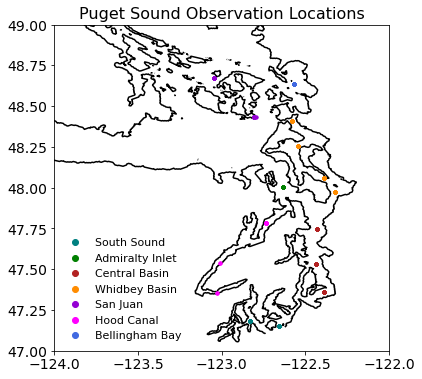

In [191]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Puget Sound Observation Locations');
ax.legend(loc="lower left",frameon=False,markerscale=2.,fontsize=11)

#fig.savefig('PugetSoundObsLocationsMap.jpg',bbox_inches='tight')

In [192]:
def byRegion(ax,obsvar,modvar,lims):
    PS=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        PS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        PS.append(PS0)
    l=ax.legend(handles=[ip[0][0] for ip in PS])
    ax.set_xlabel('Observations')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return PS,l

In [193]:
data['Month']=[ii.month for ii in data['dtUTC']]
JF=data.loc[(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SOND=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)|(data.Month==12)]

In [194]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    PS=et.varvarPlot(ax[0],JF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    PS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    PS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    PS=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

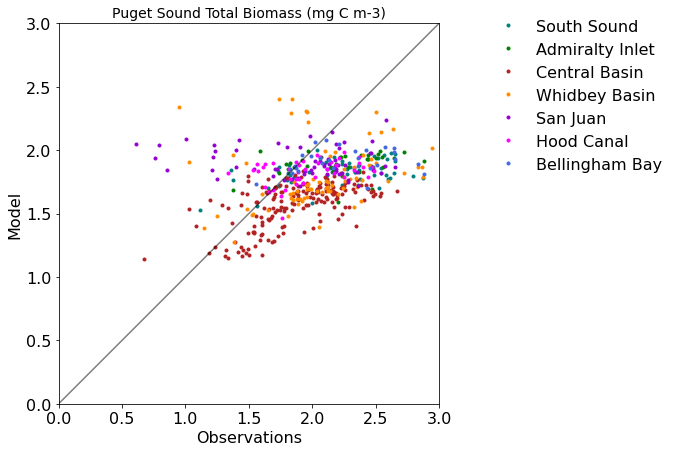

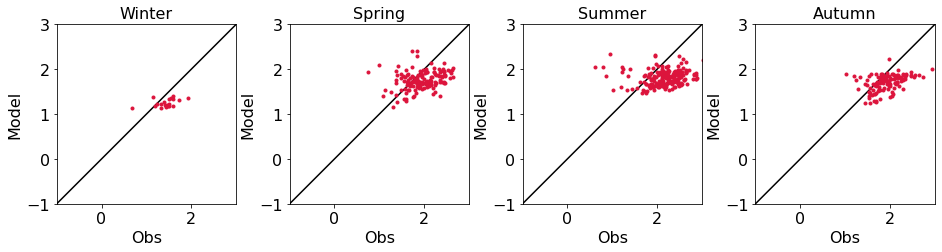

In [195]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10Total','L10mod_total',(-0,3))
ax.set_title('Puget Sound Total Biomass (mg C m-3)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False)
#fig.savefig('PugetSoundTotalBiomassModvsObs.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Total','L10mod_total',(-1,3))



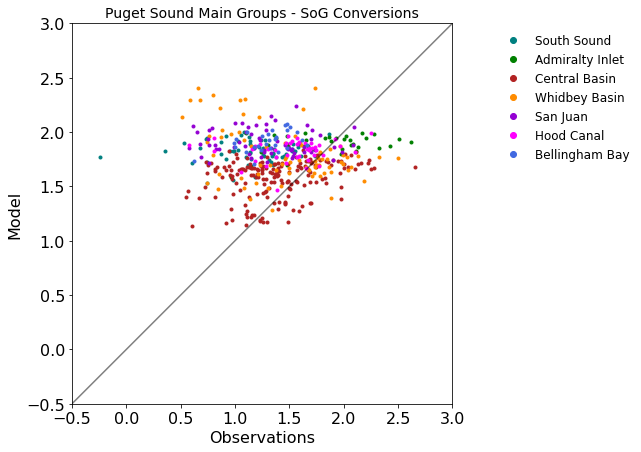

In [212]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10MainGroups','L10mod_total',(-0.5,3))
ax.set_title('Puget Sound Main Groups - SoG Conversions',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=12,markerscale=2.,frameon=False)
#fig.savefig('PugetSoundModvsObsSoGConversions.jpg',bbox_inches='tight')
#fig, ax = plt.subplots(1,4,figsize = (16,3.3))
#bySeason(ax,'L10Total','L10mod_mesozooplankton',(-1,3))



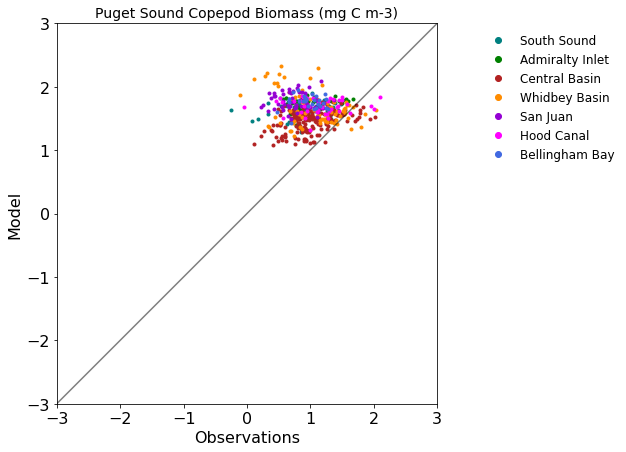

In [197]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10Copepods','L10mod_mesozooplankton',(-3,3))
ax.set_title('Puget Sound Copepod Biomass (mg C m-3)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=12,frameon=False,markerscale=2.)
#fig.savefig('PugetSoundMainGroupsBiomassModvsObs.jpg',bbox_inches='tight')

#fig, ax = plt.subplots(1,4,figsize = (16,3.3))
#bySeason(ax,'L10MainGroups','L10mod_mesozooplankton',(-1,3))

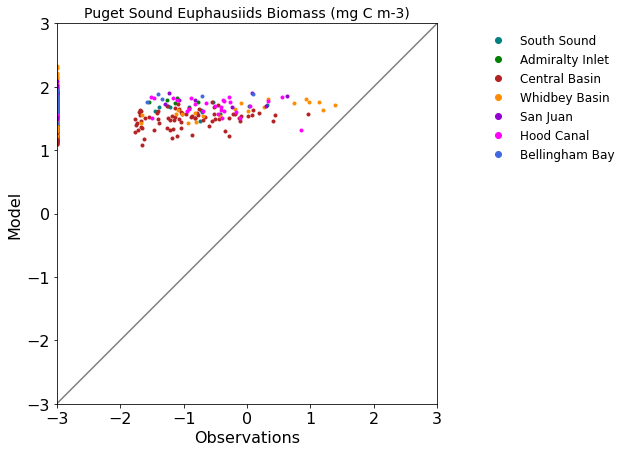

In [198]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10Euphausiids','L10mod_mesozooplankton',(-3,3))
ax.set_title('Puget Sound Euphausiids Biomass (mg C m-3)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),fontsize=12,frameon=False,markerscale=2.)
#fig.savefig('PugetSoundMainGroupsBiomassModvsObs.jpg',bbox_inches='tight')

#fig, ax = plt.subplots(1,4,figsize = (16,3.3))
#bySeason(ax,'L10MainGroups','L10mod_mesozooplankton',(-1,3))

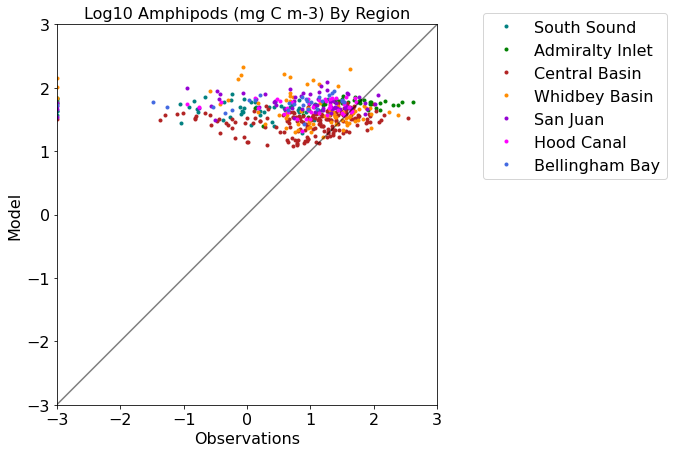

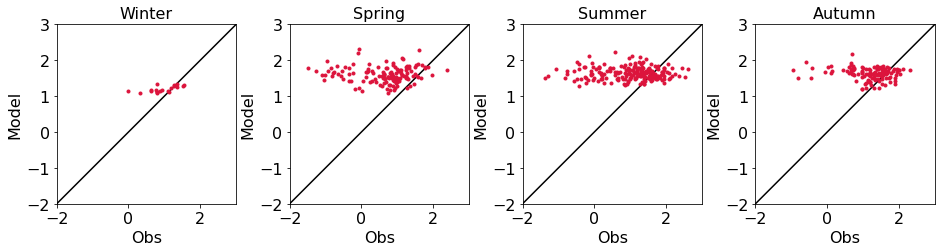

In [199]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10Amphipods','L10mod_mesozooplankton',(-3,3))
ax.set_title('Log10 Amphipods (mg C m-3) By Region')
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Amphipods','L10mod_mesozooplankton',(-2,3))

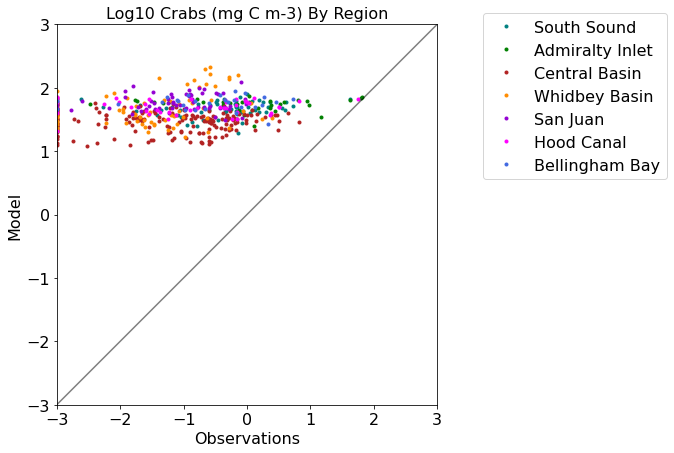

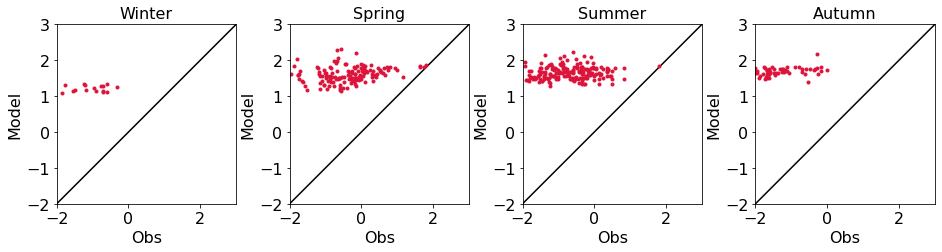

In [200]:
fig, ax = plt.subplots(1,1,figsize = (16,7))     
PS,l=byRegion(ax,'L10Crabs','L10mod_mesozooplankton',(-3,3))
ax.set_title('Log10 Crabs (mg C m-3) By Region')
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Crabs','L10mod_mesozooplankton',(-2,3))

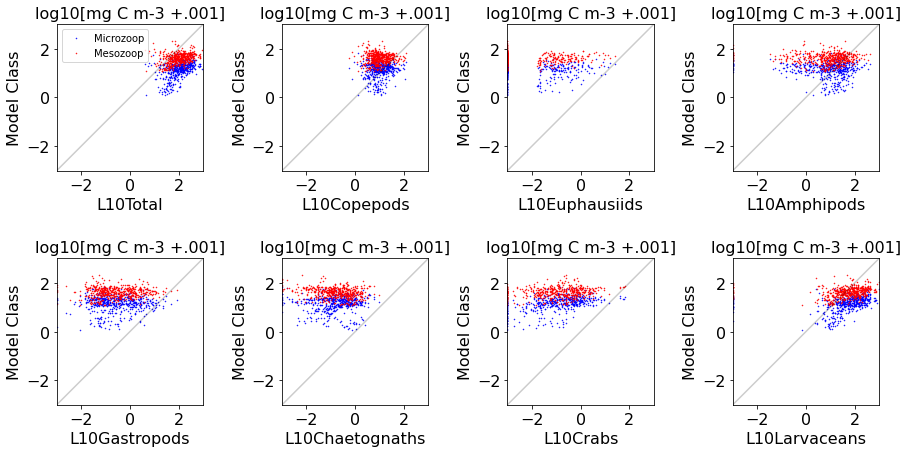

In [201]:
fig,ax=plt.subplots(2,4,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
fig.subplots_adjust(hspace=.6)
ax=ax.flatten()

taxa=('L10Total', 'L10Copepods','L10Euphausiids','L10Amphipods','L10Gastropods','L10Chaetognaths',\
    'L10Crabs','L10Larvaceans')

mvar1=data['L10mod_microzooplankton']
mvar2=data['L10mod_mesozooplankton']

for ii in range(0,len(taxa)):
    ax[ii].plot((data.loc[:,[taxa[ii]]].values),(mvar1),'.',ms=1,color='blue',label='Microzoop')
    ax[ii].plot((data.loc[:,[taxa[ii]]].values),(mvar2),'.',ms=1,color='red',label='Mesozoop')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(taxa[ii])
    ax[ii].set_title('log10[mg C m-3 +.001]')
    ax[ii].plot((-3,3),(-3,3),'k-',alpha=.2)
    ax[ii].set_xlim((-3,3))
    ax[ii].set_ylim((-3,3))
    ax[ii].set_aspect(1)
ax[0].legend(loc=2, fontsize = 'medium')

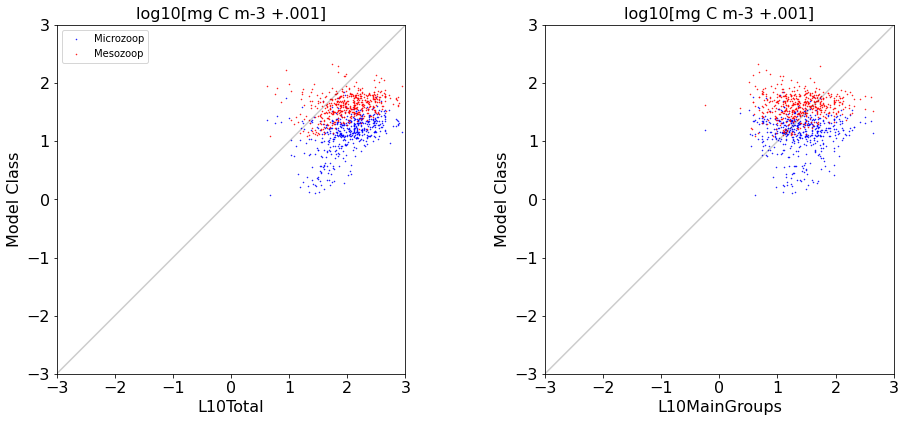

In [202]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
fig.subplots_adjust(hspace=.6)
ax=ax.flatten()

taxa=('L10Total','L10MainGroups')

mvar1=data['L10mod_microzooplankton']
mvar2=data['L10mod_mesozooplankton']

for ii in range(0,len(taxa)):
    ax[ii].plot((data.loc[:,[taxa[ii]]].values),(mvar1),'.',ms=1,color='blue',label='Microzoop')
    ax[ii].plot((data.loc[:,[taxa[ii]]].values),(mvar2),'.',ms=1,color='red',label='Mesozoop')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(taxa[ii])
    ax[ii].set_title('log10[mg C m-3 +.001]')
    ax[ii].plot((-3,3),(-3,3),'k-',alpha=.2)
    ax[ii].set_xlim((-3,3))
    ax[ii].set_ylim((-3,3))
    ax[ii].set_aspect(1)
ax[0].legend(loc=2, fontsize = 'medium')

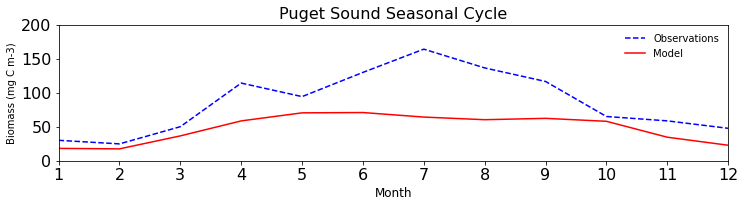

In [203]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))

ax.plot(logt_inv(monthlymean['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymean['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,200)
ax.set_xlim(1,12)
ax.set_title('Puget Sound Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.set_xlabel('Month',fontsize=12)
ax.set_xticks(np.arange(0+1,12+1,1))
ax.legend(fontsize=10,frameon=False)
fig.savefig('PugetSoundSeasonalCycle.jpg',bbox_inches='tight')

#fig,ax=plt.subplots(1,1,figsize=(12,2.5))
#ax.plot(logt_inv(monthlymean['L10mod_mesozooplankton']),'--',color='red',label='Model Microzoop')
#ax.set_ylim(0,70)
#ax.set_title('Model Mesozooplankton Seasonal Cycle')
#ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)

#fig,ax=plt.subplots(1,1,figsize=(12,2.5))
#ax.plot(logt_inv(monthlymean['L10mod_microzooplankton']),'--',color='darkorange',label='Model Microzoop')
#ax.set_ylim(0,70)
#ax.set_title('Model Microzooplankton Seasonal Cycle')
#ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)

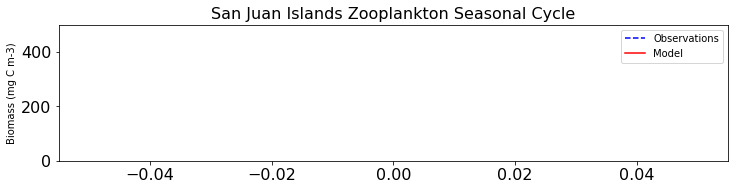

In [204]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanSanJuan['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanSanJuan['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,500)
ax.set_title('San Juan Islands Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)

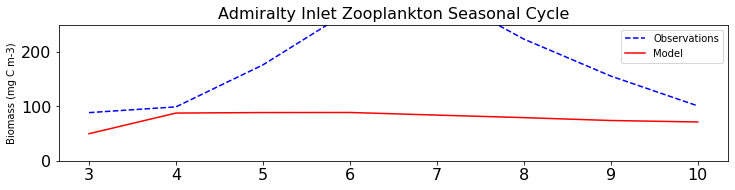

In [205]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanAdmiralty['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanAdmiralty['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,250)
ax.set_title('Admiralty Inlet Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)


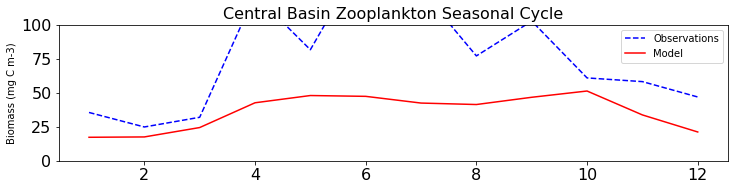

In [206]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanCentral['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanCentral['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,100)
ax.set_title('Central Basin Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)

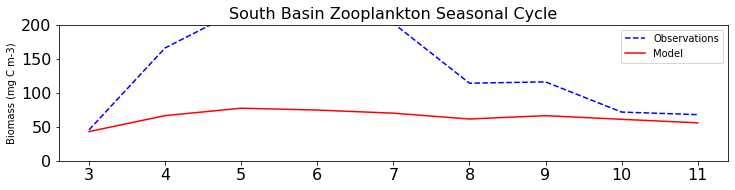

In [207]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanSouth['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanSouth['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,200)
ax.set_title('South Basin Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)

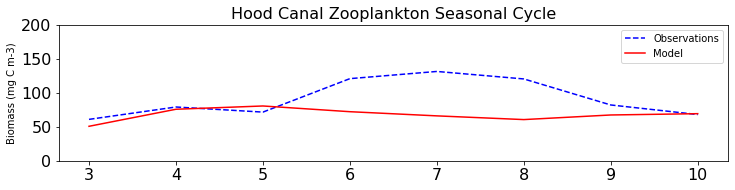

In [208]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanHood['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanHood['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,200)
ax.set_title('Hood Canal Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)

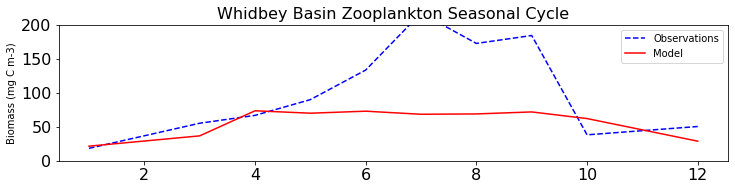

In [209]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))


ax.plot(logt_inv(monthlymeanWhidbey['L10Total']),'b--',label='Observations')
ax.plot(logt_inv(monthlymeanWhidbey['L10mod_total']),'-',color='red',label='Model')
ax.set_ylim(0,200)
ax.set_title('Whidbey Basin Zooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10)